In [1]:
import networkx as nx
import astropy.stats
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
# import itertools
# from palettable import wesanderson
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import warnings
import scipy
# from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


## Data preparation

In [2]:
# less_important_features = ['race_other', 'mood_or_anx', 'prev_study_oth_calc', 'race_asian', 'mood_anx', 
#                                  'multiple_birth', 'race_native_amer', 'gen_test_oth_calc', 
#                                  'gen_dx_oth_calc_self_report', 'growth_oth_calc', 'race_native_hawaiian']

In [3]:
# age_cols = ['age_at_eval_months', 'age_at_eval_years', 'age_at_registration_months']
race_cols = ['race_asian','race_african_amer', 'race_native_amer', 'race_native_hawaiian',
       'race_white', 'race_other', 'hispanic']

In [5]:
spark_df = pd.read_csv('./spark_cleaned_data_more_features.csv')
spark_df_asd = spark_df['asd']
id_cols = ['asd','subject_sp_id', 'respondent_sp_id', 'family_id', 'biomother_id','biofather_id']
spark_df = spark_df.drop(id_cols, axis=1)
# spark_df_selected_feat  = spark_df.drop(less_important_features, axis=1)
# spark_df_selected_feat  = spark_df.drop(age_cols, axis=1)
spark_df_selected_feat  = spark_df.drop(race_cols, axis=1)
selected_features =  spark_df_selected_feat.columns

In [6]:
spark_df_selected_feat

,mood_hoard,dev_motor,mood_sep_anx,mood_soc_anx,birth_oth_calc,behav_intermitt_explos,behav_adhd,dev_lang,attn_behav,dev_soc_prag,...,sex,dev_mutism,mood_ocd,mood_bipol,behav_odd,dev_lang_dis,gen_dx_oth_calc_self_report,mood_dep,behav_conduct,multiple_birth
0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,...,1,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0
1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0.0,...,0,0.0,1.0,1.0,0.0,0.0,0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,1.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131806,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
131807,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0
131808,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
131809,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,...,0,0.0,0.0,1.0,1.0,0.0,0,1.0,0.0,0


[59.61, 61.029999999999994, 61.650000000000006, 61.650000000000006, 61.634, 61.13444444444445, 60.62544097230125]
[40.39, 38.97, 38.35, 38.35, 38.366, 38.86555555555555, 39.37455902769875]


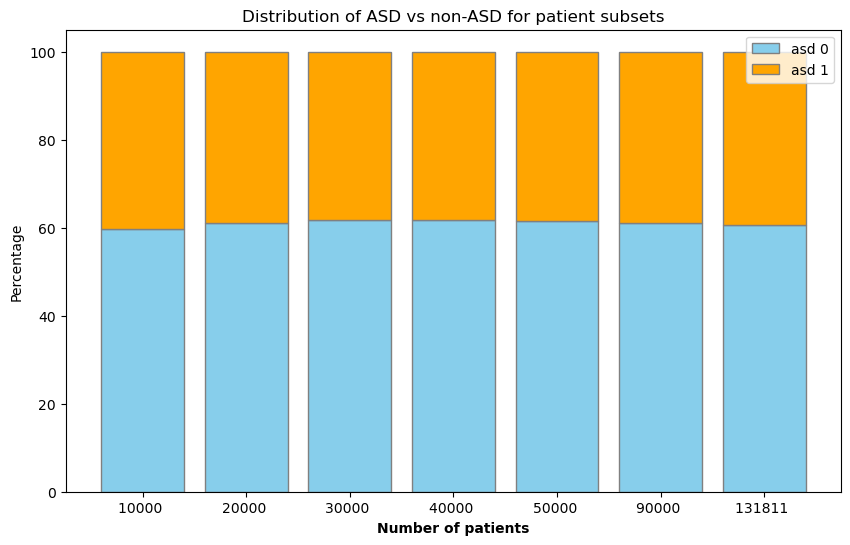

In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

def plot_asd_distribution_percentages_stacked(spark_sr, num_patients_list):
    plt.figure(figsize=(10, 6))
    
    # Colors for different asd categories
    colors = ['skyblue', 'orange']
    
    # Positions of the bars on the x-axis
    r = np.arange(len(num_patients_list))
    
    bottom = np.zeros(len(num_patients_list))  # Starting point for the stacks
    
    for asd_category in [0, 1]:  # Assuming asd categories are 0 and 1
        percentages = []
        
        for num_patients in num_patients_list:
            # Limit the DataFrame to the first num_patients rows
            spark_df = spark_sr.to_frame(name='asd')
            subset_df = spark_df.iloc[:num_patients]
            
            # Calculate the percentage for the current asd category
            category_count = subset_df[subset_df['asd'] == asd_category].shape[0]
            percentage = (category_count / num_patients) * 100
            percentages.append(percentage)
        
        # Plotting
        print(percentages)
        plt.bar(r, percentages, color=colors[asd_category], edgecolor='grey', label=f'asd {asd_category}', bottom=bottom)
        bottom += np.array(percentages)  # Update the starting point for the next stack
    
    plt.xlabel('Number of patients', fontweight='bold')
    plt.xticks(r, [f'{n} ' for n in num_patients_list])
    plt.ylabel('Percentage')
    plt.title('Distribution of ASD vs non-ASD for patient subsets')
    
    plt.legend()
    plt.show()

# Assuming spark_df_asd is a Series-like object with 'asd' values
# Plotting for the first 10k, 20k, and 30k patients in one stacked plot
plot_asd_distribution_percentages_stacked(spark_df_asd, [10000, 20000, 30000, 40000, 50000, 90000, len(spark_df_asd)])

## Calculating similarity matrix

In [9]:

# # Calculate cosine similarity
# cosine_sim_matrix = cosine_similarity(spark_df_selected_feat)

# # Convert the cosine similarity matrix to a DataFrame
# cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=spark_df_selected_feat.index, columns=spark_df_selected_feat.index)

In [10]:
spark_df_selected_feat = spark_df_selected_feat.astype(bool)

In [11]:
import sys

# Assuming spark_df_selected_feat is your object
memory_usage = sys.getsizeof(spark_df_selected_feat)

print(f"Memory usage: {memory_usage} bytes")

Memory usage: 3559041 bytes


In [12]:
spark_df_selected_feat

,mood_hoard,dev_motor,mood_sep_anx,mood_soc_anx,birth_oth_calc,behav_intermitt_explos,behav_adhd,dev_lang,attn_behav,dev_soc_prag,...,sex,dev_mutism,mood_ocd,mood_bipol,behav_odd,dev_lang_dis,gen_dx_oth_calc_self_report,mood_dep,behav_conduct,multiple_birth
0,False,False,False,False,False,False,True,True,True,False,...,True,False,False,False,False,True,False,False,False,False
1,False,False,False,True,False,False,True,False,True,False,...,False,False,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131806,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
131807,False,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
131808,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
131809,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,True,False,False,True,False,False


In [13]:
def pairwise_hamming_similarity(df):
    # Convert the DataFrame to a boolean array if not already
    # data_bool = df.astype(bool)
    data_bool = df
    
    # Compute pairwise Hamming distances
    pairwise_dist = pdist(data_bool, metric='hamming')
    
    # Convert distances to similarities
    pairwise_sim = 1 - pairwise_dist
    
    # Convert the condensed distance matrix to a square matrix
    similarity_matrix = squareform(pairwise_sim)
    similarity_df = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)
    
    return similarity_df

# hamming_sim_df_50k = pairwise_hamming_similarity(spark_df_selected_feat.iloc[:50000])
# 1.5 mins

In [14]:
# hamming_sim_df_80k = pairwise_hamming_similarity(spark_df_selected_feat.iloc[:80000])
# 4 mins

In [15]:
# hamming_sim_df_90k = pairwise_hamming_similarity(spark_df_selected_feat.iloc[:90000])
# 5 mins


## Building Patient Similarity Network from similarity matrix

In [16]:
def print_graph_info(G):
    """
    Prints basic information about the graph.
    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print("Sample nodes:", list(G.nodes)[:10])  # Print first 10 nodes as a sample
    print("Sample edges:", list(G.edges(data=True))[:10])  # Print first 10 edges as a sample
    
    # Check for self-loops
    self_loops = list(nx.selfloop_edges(G))
    if self_loops:
        print(f"Number of self-loops: {len(self_loops)}")
        print("Self-loops:", self_loops)
    else:
        print("No self-loops in the graph.")

def calculate_average_clustering(G):
    """
    Calculates and prints the average clustering coefficient of the graph.
    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering}")

### KNN

#### KNN graph builing algorithm

In [17]:
def get_k_neighbors(sim_matrix_df, k_neighbors):
    '''
    Helper function to get the k-nearest neighbors for each node in the graph
    sim_matrix_df : pd.DataFrame containing the similarity matrix of patient data
    k_neighbors : number of nearest neighbors to consider

    retruns : dictionary where keys are the indices of the nodes/patients and values are lists of the indices of the k-nearest neighbors
    e.g. {0: [3, 1, 4], 1: [0, 3, 2], 2: [3, 1, 0], 3: [0, 1, 2], 4: [0, 3, 1]}
    '''
    print('Using Eucledian distance')
    # Compute euclidean distance matrix
    dist_mtx = scipy.spatial.distance_matrix(sim_matrix_df.values ,  sim_matrix_df.values)
    dist_mtx = pd.DataFrame(dist_mtx , index = sim_matrix_df.index , columns = sim_matrix_df.index)
    
    k_neighbors_dict = {}
    for node in dist_mtx.index:

        neighbors = dist_mtx.loc[node].nsmallest(k_neighbors + 1).index.tolist() 
        try: 
            neighbors.remove(node) # Exclude the node itself
        except ValueError:
            pass
            # print('ValueError: Node {} is not in top k neighbors'.format(node))
            # print(dist_mtx.loc[node].nsmallest(k_neighbors + 1))
        
        k_neighbors_dict[node] = neighbors

    return k_neighbors_dict

def get_k_neighbors_directly(sim_matrix_df, k_neighbors):
    '''
    Helper function to get the k-nearest neighbors for each node in the graph
    sim_matrix_df : pd.DataFrame containing the similarity matrix of patient data
    k_neighbors : number of nearest neighbors to consider

    retruns : dictionary where keys are the indices of the nodes/patients and values are lists of the indices of the k-nearest neighbors
    e.g. {0: [3, 1, 4], 1: [0, 3, 2], 2: [3, 1, 0], 3: [0, 1, 2], 4: [0, 3, 1]}
    '''
    
    # print('NO Eucledian distance')


    k_neighbors_dict = {}
    for node in sim_matrix_df.index:

        # neighbors = sim_matrix_df.loc[node].nsmallest(k_neighbors + 1).index.tolist() 
        neighbors = sim_matrix_df.loc[node].nlargest(k_neighbors + 1).index.tolist() 
        try: 
            neighbors.remove(node) # Exclude the node itself
        except ValueError:
            pass
            # print('ValueError: Node {} is not in top k neighbors'.format(node))
            # print sim_matrix_df.loc[node].nsmallest(k_neighbors + 1))
        
        k_neighbors_dict[node] = neighbors
        

    return k_neighbors_dict

def build_network_knn(sim_matrix_df , labels,  k_neighbors = 20, compute_knn_directly = False) : 
    '''
    sim_matrix_df : pd.DataFrame containing the similarity matrix of patient data
    labels : pd.Series indicating asd status for each patient
    k_neighbors : number of nearest neighbors to consider
    '''

    if compute_knn_directly:
        k_neighbors_dict = get_k_neighbors_directly(sim_matrix_df, k_neighbors)
    else:
        k_neighbors_dict = get_k_neighbors(sim_matrix_df, k_neighbors)

    # Create a NetworkX graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(sim_matrix_df.index)

    nx.set_node_attributes(G , labels , 'label')
    nx.set_node_attributes(G , pd.Series(np.arange(len(sim_matrix_df.index)) , index=sim_matrix_df.index) , 'idx')

    # Add edges based on the k-nearest neighbors
    for node, neighbors in k_neighbors_dict.items():
        for neighbor in neighbors:
            if node == neighbor:
                print('Node {} is its own neighbor'.format(node))
            G.add_edge(node, neighbor)

    return G 

def plot_network(G , label_colours = ['skyblue', 'orange'] , node_size = 50, 
                 title = 'Patient Similarity Network', with_labels = False) :

    # plt.figure(figsize=(10, 8))
    # Define color map based on labels, 0 is non-ASD, 1 is ASD
    label_colour_map = {0: label_colours[0] , 1 : label_colours[1]}
    node_colours = [label_colour_map[G.nodes[node]['label']] for node in G]

    pos = nx.spring_layout(G, seed=42)  # seed ensures layout is the same each run

    # nx.draw(G, pos, with_labels=False, node_color=node_colours,
                #  node_size=node_size, font_size=8, alpha=0.3)

    nx.draw_networkx_nodes(G, pos, node_color=node_colours, node_size=node_size, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    if with_labels:
        node_labels = nx.get_node_attributes(G, 'idx')  
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    # Create a patch list for the legend
    label_names = ['No ASD', 'ASD']
    legend_patches = [mpatches.Patch(color=colour, label=label) for label, colour in zip(label_names, label_colours)]

    plt.legend(handles=legend_patches)
    plt.title(title)

    plt.show()
    

#### Example graph with KNN

In [18]:
# n = 500
# k = 20
# cosine_sim_df_small = hamming_sim_df_90k.iloc[:n, :n]

# # G_knn_small = build_network_knn(cosine_sim_df_small, spark_df_asd.iloc[:n], k_neighbors=k, compute_knn_directly=False)
# # title = f"Patient Similarity Network with KNN (n={n}, k={k})"
# # print_graph_info(G_knn_small)
# # plot_network(G_knn_small, node_size=10, title = title)

# G_knn_small = build_network_knn(cosine_sim_df_small, spark_df_asd.iloc[:n], k_neighbors=k, compute_knn_directly=True)
# title = f"Patient Similarity Network with KNN (n={n}, k={k})"
# print_graph_info(G_knn_small)
# plot_network(G_knn_small, node_size=10, title = title)

### Thresholding

In [19]:
def build_network_threshold(sim_matrix_df, labels, threshold=0.8):
    """
    Creates a graph from a correlation matrix using a specified threshold.

    Parameters:
    sim_matrix_df (pd.DataFrame): DataFrame containing the correlation matrix.
    labels (pd.Series): Series containing the labels for each patient.
    threshold (float): Threshold for including edges based on similarity value.

    Returns:
    G (nx.Graph): Graph created from the similarity matrix.
    """
    G = nx.Graph()

    # # Add nodes
    # for node in sim_matrix_df.columns:
    #     G.add_node(node)

    
    # Add nodes to the graph
    G.add_nodes_from(sim_matrix_df.index)

    nx.set_node_attributes(G , labels , 'label')
    nx.set_node_attributes(G , pd.Series(np.arange(len(sim_matrix_df.index)) , index=sim_matrix_df.index) , 'idx')

    # Add edges with weights above the threshold
    for i in range(sim_matrix_df.shape[0]):
        for j in range(i + 1, sim_matrix_df.shape[1]):
            if i != j:  # Ignore the diagonal elements
                weight = sim_matrix_df.iloc[i, j]
                if abs(weight) >= threshold:
                    G.add_edge(sim_matrix_df.index[i], sim_matrix_df.columns[j], weight=weight)

    return G



In [20]:
# n = 100
# t = 0.8
# cosine_sim_df_small = hamming_sim_df_90k.iloc[:n, :n]
# G_small_threshold = build_network_threshold(cosine_sim_df_small, spark_df_asd.iloc[:n] ,threshold=t)
# print_graph_info(G_small_threshold)
# calculate_average_clustering(G_small_threshold)
# title = f"Patient Similarity Network with Threshold (n={n}, threshold=0.8)"
# plot_network(G_small_threshold, node_size=10, title = title)

## Cleaning the graph

In [21]:
def clean_graph(G, degree_threshold=1, keep_largest_component=True, knn=False):
    """
    Cleans the graph by performing several cleaning steps:
    - Removes unconnected nodes (isolates)
    - Removes self-loops
    - Removes nodes with a degree below a specified threshold
    - Keeps only the largest connected component (optional)

    Parameters:
    G (nx.Graph): The NetworkX graph to clean.
    degree_threshold (int): Minimum degree for nodes to keep.
    keep_largest_component (bool): Whether to keep only the largest connected component.

    Returns:
    G (nx.Graph): Cleaned graph.
    """
    # Remove self-loops - this is already done when building the graph
    # G.remove_edges_from(nx.selfloop_edges(G))

    # Remove nodes with no edges (isolates), no isolates possible if using knn => this not needed if we only keep largest component
    # if knn == False:
    #     G.remove_nodes_from(list(nx.isolates(G)))

    # Remove nodes with degree below the threshold
    if degree_threshold > 1:
        low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < degree_threshold]
        G.remove_nodes_from(low_degree_nodes)

    # Keep only the largest connected component
    if keep_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc)

    return G

In [22]:
# # Clean the graph by removing unconnected nodes
# G_small_threshold_cleaned = clean_graph(G_small_threshold,
#                                     degree_threshold=5,
#                                     keep_largest_component=False)
# plot_network(G_small_threshold_cleaned, node_size=10, title=f'Cleaned Patient Similarity Network (n={n}, threshold={t})'.format(n,t))

In [23]:
# # Clean the graph by removing unconnected nodes
# G_small_threshold_cleaned2 = clean_graph(G_small_threshold,
#                                     degree_threshold=20,
#                                     keep_largest_component=False)
# plot_network(G_small_threshold_cleaned2, node_size=10, title=f'Cleaned Patient Similarity Network (n={n}, threshold={t})'.format(n,t))


In [24]:
# # Clean the graph by removing unconnected nodes
# G_small_threshold_cleaned3 = clean_graph(G_small_threshold,
#                                     degree_threshold=5,
#                                     keep_largest_component=True)
# plot_network(G_small_threshold_cleaned, node_size=10, title=f'Cleaned Patient Similarity Network (n={n}, threshold={t})'.format(n,t))


## Clustering

In [25]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, rand_score

In [26]:
def get_clusters(G, k=2):
    """
    Performs spectral clustering on the graph and returns the cluster labels.

    Parameters:
    G (nx.Graph): The NetworkX graph.
    k (int): Number of clusters.

    Returns:
    cluster_labels (np.array): Array of cluster labels.
    """
    # Convert the graph into an adjacency matrix
    adjacency_matrix = nx.to_numpy_array(G)

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=100)
    cluster_labels = sc.fit_predict(adjacency_matrix)

    return cluster_labels



def plot_network_clusters(G , cluster_labels, node_size = 50, 
                          title = 'Patient Similarity Network', with_labels = False) :

    # plt.figure(figsize=(10, 8))

    pos = nx.spring_layout(G, seed=42)  # seed ensures layout is the same each run


    # Create a color map from labels to colors
    unique_cluster_labels = np.unique(cluster_labels)
    node_colours = [plt.cm.jet(label / max(unique_cluster_labels)) for label in cluster_labels]

    nx.draw_networkx_nodes(G, pos, node_color=node_colours, node_size=node_size, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    if with_labels:
        node_labels = nx.get_node_attributes(G, 'idx')  
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    # Create a patch list for the legend
    legend_handles = [mpatches.Patch(color=plt.cm.jet(i / max(unique_cluster_labels)), label=f'Cluster {i+1}') for i in unique_cluster_labels]

    plt.legend(handles=legend_handles)
    plt.title(title)

    plt.show()



In [27]:
n = 10000
hamming_sim_df = pairwise_hamming_similarity(spark_df_selected_feat.iloc[:n])   

In [29]:
import gc
import psutil
import time

def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    virtual_mem = psutil.virtual_memory()
    print("---------------------------------")
    print(f"Process Memory Usage: {mem_info.rss / (1024 ** 3):.2f} GB")
    print(f"Total Memory: {virtual_mem.total / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {virtual_mem.available / (1024 ** 3):.2f} GB")
    print(f"Used Memory: {virtual_mem.used / (1024 ** 3):.2f} GB")
    print(f"Memory Percentage: {virtual_mem.percent}%")
    print("---------------------------------")

In [33]:
# G_knn_small = build_network_knn(cosine_sim_df_small, spark_df_asd.iloc[:n], k_neighbors=k, compute_knn_directly=True)
# title = f"Patient Similarity Network with KNN (n={n}, k={k})"
# print_graph_info(G_knn_small)
# plot_network(G_knn_small, node_size=10, title = title)

n = 10000
# n = 1000
# n = 20000
sim_df = hamming_sim_df.iloc[:n, :n]
asd_labels = spark_df_asd.iloc[:n]

# k_neighbors_range = [5, 10, 20, 50, 100]
# k_neighbors_range = [5, 10, 20, 50, 100, 200, 300, 500]
# k_neighbors_range = [200, 300, 500, 600, 700, 800, 900, 1000]
# k_neighbors_range = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# k_neighbors_range = [7000, 8000, 9000, 10000]
# k_neighbors_range = [5000, 6000, 7000]
# percentagewise best values 
k_neighbors_range = [10000, 12000, 14000]
# k_neighbors_range = [6000, 7000]

# Initialize a dictionary to store graphs and their Rand indices
graphs_and_scores_knn = {}

for k in k_neighbors_range:
    print_memory_usage()
    start = time.time()
    print(f'Building kNN graph for k={k}...')
    # Generate the kNN graph for the current k
    G = build_network_knn(sim_df, asd_labels, k_neighbors=k, compute_knn_directly=True)
    print_memory_usage()

    G = clean_graph(G, degree_threshold=1, keep_largest_component=True)
    print('Number of nodes after cleaning:', G.number_of_nodes())
    print_memory_usage()
    
    print('Getting clusters...')
    # Cluster the graph
    cluster_labels = get_clusters(G, k=2)
    
    # Calculate the Rand index
    true_labels = asd_labels.iloc[:G.number_of_nodes()].to_numpy()
    rand_index = rand_score(true_labels, cluster_labels)
    adjusted_rand_index = adjusted_rand_score(true_labels, cluster_labels)

    print(f'k={k}, Rand index={rand_index:.4f}, Adjusted Rand index={adjusted_rand_index:.4f}')
    print()
    print(f"Time taken: {(time.time() - start)/60:.2f} minutes")

    # Clear variables to free up memory
    print_memory_usage()
    del G, cluster_labels, true_labels
    gc.collect()
    print("garbage collected")
    print_memory_usage()
    print("=====================================")
    
    # Store the graph and Rand index
    # graphs_and_scores_knn[k] = {'graph': G, 'rand_index': rand_index, 'adjusted_rand_index': adjusted_rand_index, 'cluster_labels': cluster_labels}

---------------------------------
Process Memory Usage: 13.02 GB
Total Memory: 220.38 GB
Available Memory: 202.79 GB
Used Memory: 16.27 GB
Memory Percentage: 8.0%
---------------------------------
Building kNN graph for k=10000...
---------------------------------
Process Memory Usage: 52.19 GB
Total Memory: 220.38 GB
Available Memory: 163.91 GB
Used Memory: 55.15 GB
Memory Percentage: 25.6%
---------------------------------
Number of nodes after cleaning: 20000
---------------------------------
Process Memory Usage: 91.05 GB
Total Memory: 220.38 GB
Available Memory: 125.01 GB
Used Memory: 94.05 GB
Memory Percentage: 43.3%
---------------------------------
Getting clusters...
k=10000, Rand index=0.5861, Adjusted Rand index=0.1722

Time taken: 23.35 minutes
---------------------------------
Process Memory Usage: 91.11 GB
Total Memory: 220.38 GB
Available Memory: 124.94 GB
Used Memory: 94.11 GB
Memory Percentage: 43.3%
---------------------------------
garbage collected
-----------------

In [28]:
# for k, info in graphs_and_scores_knn.items():
#     G = info['graph']
#     rand_index = info['rand_index']
#     cluster_labels = info['cluster_labels']
    

#     title = f'Graph with k={k}, Rand Index: {rand_index:.4f}'
#     plot_network_clusters(G, cluster_labels = cluster_labels, title=title)
    

In [39]:


n = 10000
# n = 300
sim_df = hamming_sim_df.iloc[:n, :n]
asd_labels = spark_df_asd.iloc[:n]

threshold_range = [0.7, 0.8, 0.9]
# threshold_range = [0.5]

# Initialize a dictionary to store graphs and their Rand indices
graphs_and_scores_threshold = {}

for t in threshold_range:
    start = time.time()
    # Generate the kNN graph for the current k
    G = build_network_threshold(sim_df, asd_labels ,threshold=t)

    # clean graph by removing unconnected nodes and those with less than 5 connections
    G = clean_graph(G, degree_threshold=1, keep_largest_component=True)
    print('Number of nodes after cleaning:', G.number_of_nodes())

    # Cluster the graph
    cluster_labels = get_clusters(G, k=2)
    
    # Calculate the Rand index
    true_labels = asd_labels.iloc[:G.number_of_nodes()].to_numpy()
    rand_index = rand_score(true_labels, cluster_labels)
    adjusted_rand_index = adjusted_rand_score(true_labels, cluster_labels)


    print(f't={t}, Rand index={rand_index:.4f}, Adjusted Rand index={adjusted_rand_index:.4f}')
    print()
    print(f"Time taken: {(time.time() - start)/60:.2f} minutes")

    # Clear variables to free up memory
    del G, cluster_labels, true_labels
    gc.collect()
    # print("garbage collected")
    # print_memory_usage()
    # print("=====================================")
    
    # Store the graph and Rand index
    # graphs_and_scores_threshold[t] = {'graph': G, 'rand_index': rand_index, 'adjusted_rand_index': adjusted_rand_index, 'cluster_labels': cluster_labels}

# 20 mins/sample

Number of nodes after cleaning: 10000
t=0.7, Rand index=0.5244, Adjusted Rand index=0.0146

Time taken: 19.21 minutes
Number of nodes after cleaning: 9999
t=0.8, Rand index=0.5235, Adjusted Rand index=0.0137

Time taken: 17.58 minutes
Number of nodes after cleaning: 9781
t=0.9, Rand index=0.5182, Adjusted Rand index=-0.0001

Time taken: 14.02 minutes


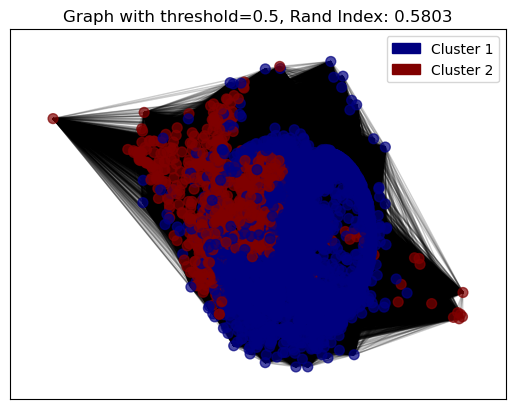

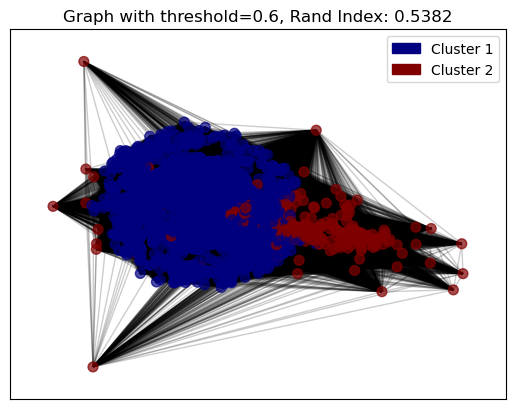

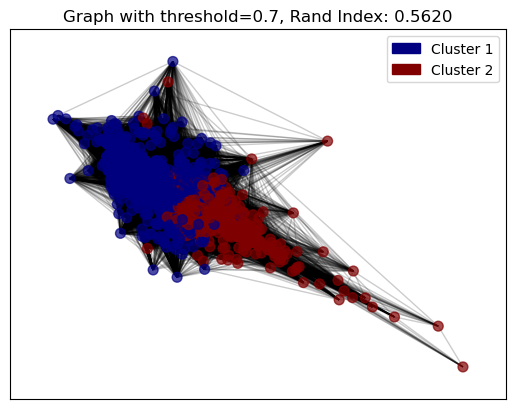

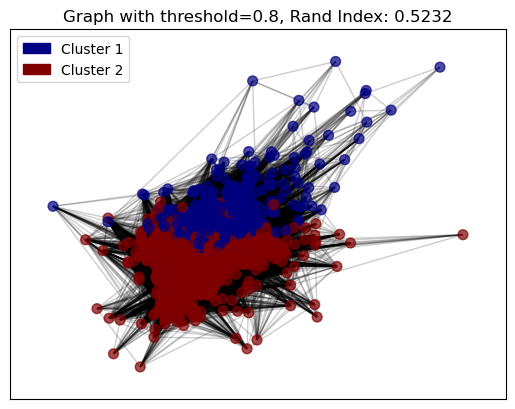

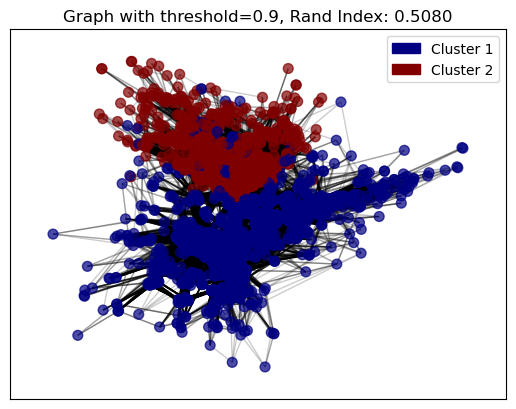

In [ ]:
# for t, info in graphs_and_scores_threshold.items():
#     G = info['graph']
#     rand_index = info['rand_index']
#     cluster_labels = info['cluster_labels']
    

#     title = f'Graph with threshold={t}, Rand Index: {rand_index:.4f}'
#     plot_network_clusters(G, cluster_labels = cluster_labels, title=title)

# # 3h
    

In [ ]:
# G = G_knn_small
# cluster_labels = get_clusters(G, k=2)
# plot_network_clusters(G, cluster_labels = cluster_labels, title='Patient Similarity Network with Clusters')
# plot_network(G, title='Patient Similarity Network with Clusters')
# # get score
# true_labels = spark_df_asd.iloc[:n].to_numpy()
# print(rand_score(true_labels, cluster_labels))


: 